In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
class VggFeatures(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        print(x.shape)

        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))

        return x


class Vgg(VggFeatures):
    def __init__(self, drop=0.2):
        super().__init__(drop)
        self.lin3 = nn.Linear(4096, 7)

    def forward(self, x):
        x = super().forward(x)
        x = self.lin3(x)
        return x

In [5]:
net = Vgg()

checkpoint = torch.load('/content/gdrive/My Drive/emotion_detection_vgg/VGGNet.tar')
net.load_state_dict(checkpoint['params'])

<All keys matched successfully>

In [6]:
net.to(device)
net.eval()

Vgg(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1a): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2a): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn

In [7]:
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

print()

conv1a.weight 	 torch.Size([64, 1, 3, 3])
conv1a.bias 	 torch.Size([64])
conv1b.weight 	 torch.Size([64, 64, 3, 3])
conv1b.bias 	 torch.Size([64])
conv2a.weight 	 torch.Size([128, 64, 3, 3])
conv2a.bias 	 torch.Size([128])
conv2b.weight 	 torch.Size([128, 128, 3, 3])
conv2b.bias 	 torch.Size([128])
conv3a.weight 	 torch.Size([256, 128, 3, 3])
conv3a.bias 	 torch.Size([256])
conv3b.weight 	 torch.Size([256, 256, 3, 3])
conv3b.bias 	 torch.Size([256])
conv4a.weight 	 torch.Size([512, 256, 3, 3])
conv4a.bias 	 torch.Size([512])
conv4b.weight 	 torch.Size([512, 512, 3, 3])
conv4b.bias 	 torch.Size([512])
bn1a.weight 	 torch.Size([64])
bn1a.bias 	 torch.Size([64])
bn1a.running_mean 	 torch.Size([64])
bn1a.running_var 	 torch.Size([64])
bn1a.num_batches_tracked 	 torch.Size([])
bn1b.weight 	 torch.Size([64])
bn1b.bias 	 torch.Size([64])
bn1b.running_mean 	 torch.Size([64])
bn1b.running_var 	 torch.Size([64])
bn1b.num_batches_tracked 	 torch.Size([])
bn2a.weight 	 torch.Size([128])
bn2a.bias 

In [8]:
frame = cv2.imread('/content/gdrive/My Drive/emotion_detection_vgg/test_img1.jpg')

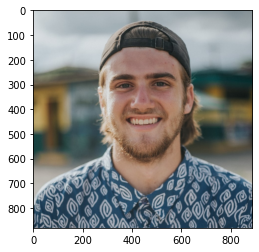

In [9]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [10]:
facecascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [11]:
frame_color = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

In [12]:
faces = facecascade.detectMultiScale(frame_color,1.1,4)
for x,y,w,h in faces:
    #roi_gray = gray[y:y+h,x:x+w]
    roi_color = frame_color[y:y+h,x:x+w]
    cv2.rectangle(frame_color,(x,y),(x+w,y+h),(255,0,0),2)
    faces1 = facecascade.detectMultiScale(roi_color)
    for (ex,ey,ew,eh) in faces1:
         face_roi = roi_color[ey: ey+eh,ex: ex+ew]   

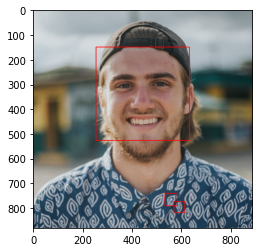

In [13]:
plt.imshow(frame_color)

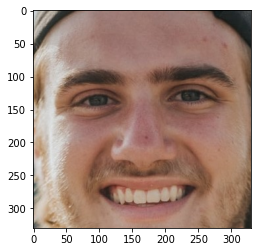

In [14]:
plt.imshow(face_roi)

In [15]:
face_roi.shape

(330, 330, 3)

In [16]:
gray = cv2.cvtColor(face_roi,cv2.COLOR_BGR2GRAY)
final_img = cv2.resize(gray,(48,48))
final_img.shape

(48, 48)

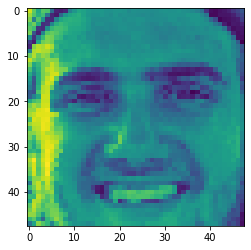

In [17]:
plt.imshow(final_img)

In [18]:
final_img.shape

(48, 48)

In [21]:
img = np.array(final_img)
img = Image.fromarray(img)
# image array = (len,48,48)

mu,st = 0, 255

test_transform = transforms.Compose([
        # transforms.Scale(52),
        transforms.TenCrop(40),
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
    ])

T_img = test_transform(img)

In [22]:
T_img.shape

torch.Size([10, 1, 40, 40])

In [23]:
data = T_img.to(device)

In [25]:
inputs = data.view(-1, 1, 40, 40)
# forward
outputs = net(inputs)
# combine results across the crops
outputs = outputs.view(1, 10, -1)
outputs = torch.sum(outputs, dim=1) / 10

torch.Size([10, 512, 2, 2])


In [32]:
_, preds = torch.max(outputs.data,1)

In [34]:
outputs


tensor([[ 2.3427, -2.3000, -1.2903,  0.2437,  0.5603,  0.0354,  0.4371]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [33]:
print(preds)

tensor([0], device='cuda:0')
